In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import detrend
import pywt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[2]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from utils.noise_test import diagnose_series

In [2]:
initial_time = pd.to_datetime('2024-01-01T12:00:00+00:00')
final_time = pd.to_datetime('2025-01-01T12:00:00+00:00')

In [3]:
tickers = ["SPY", "TSLA", "NVDA", "BRK-B"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

<h1>Stack</h1>

In [4]:
from signal_modules._regressors._oracle_base import StackedOracle

In [5]:
from signal_modules._regressors.Kalman_filter import KalmanFilter

kalman1 = KalmanFilter(
    alpha=1,
    process_noise=1e-3,
    obs_noise_scale=1e+5
)
kalman2 = KalmanFilter(
    process_noise=1e-3,
    obs_noise_scale=1e+5
)

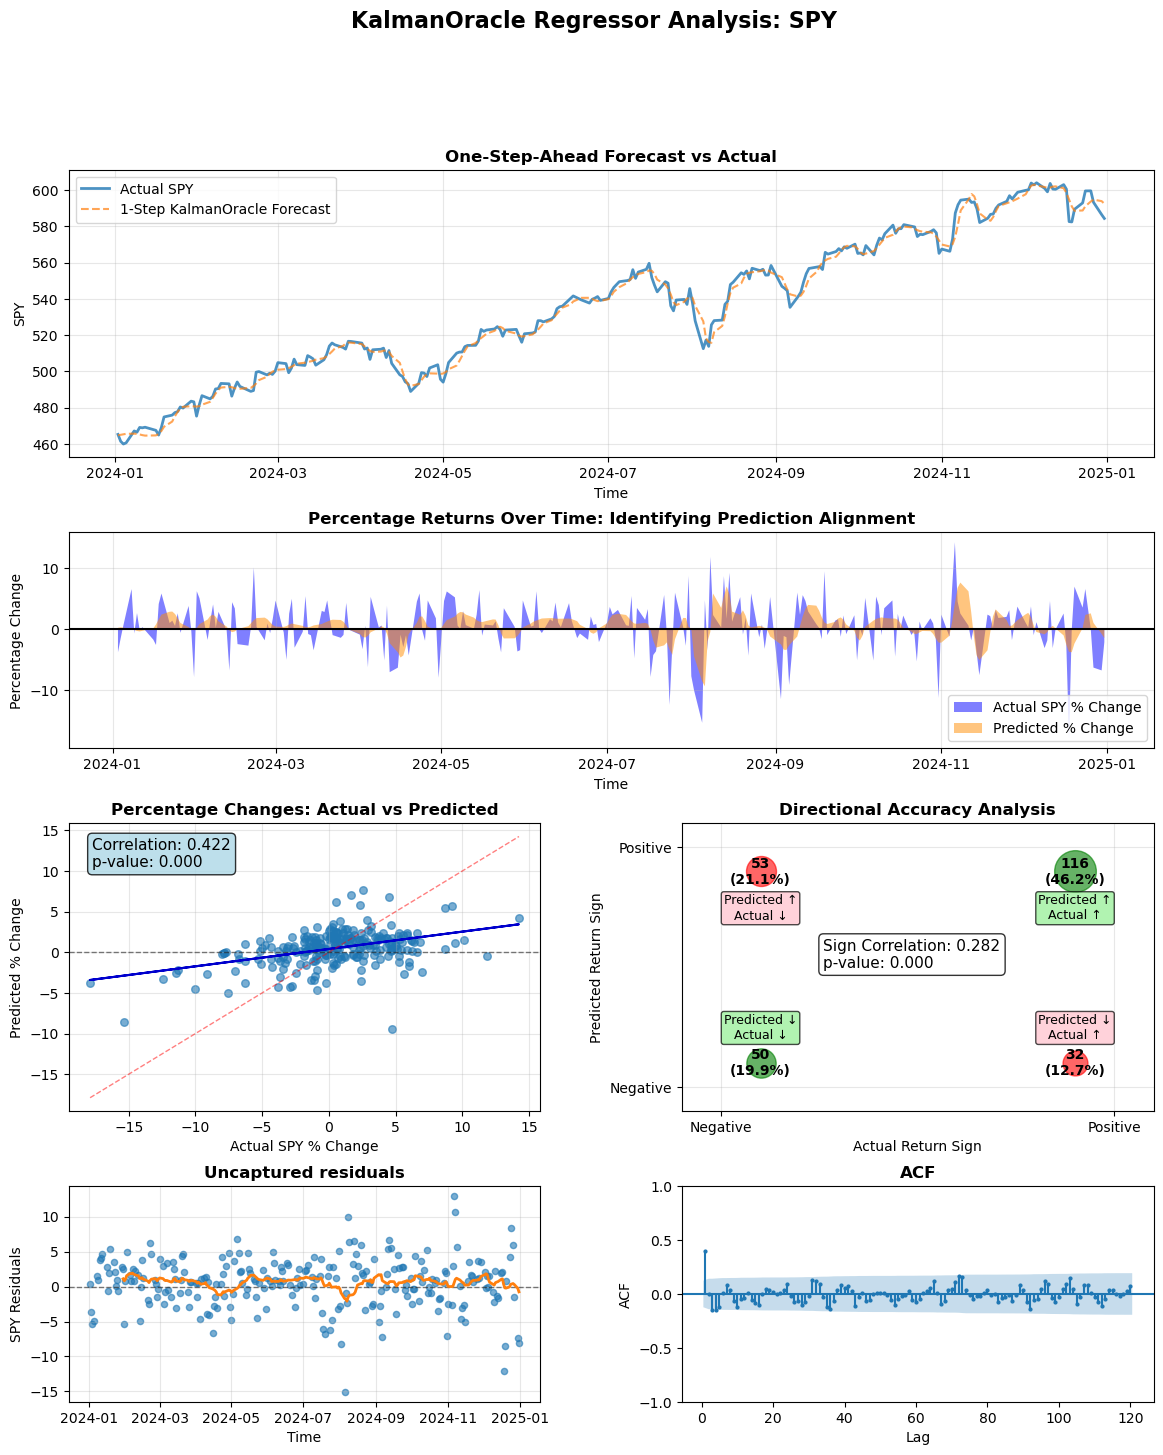

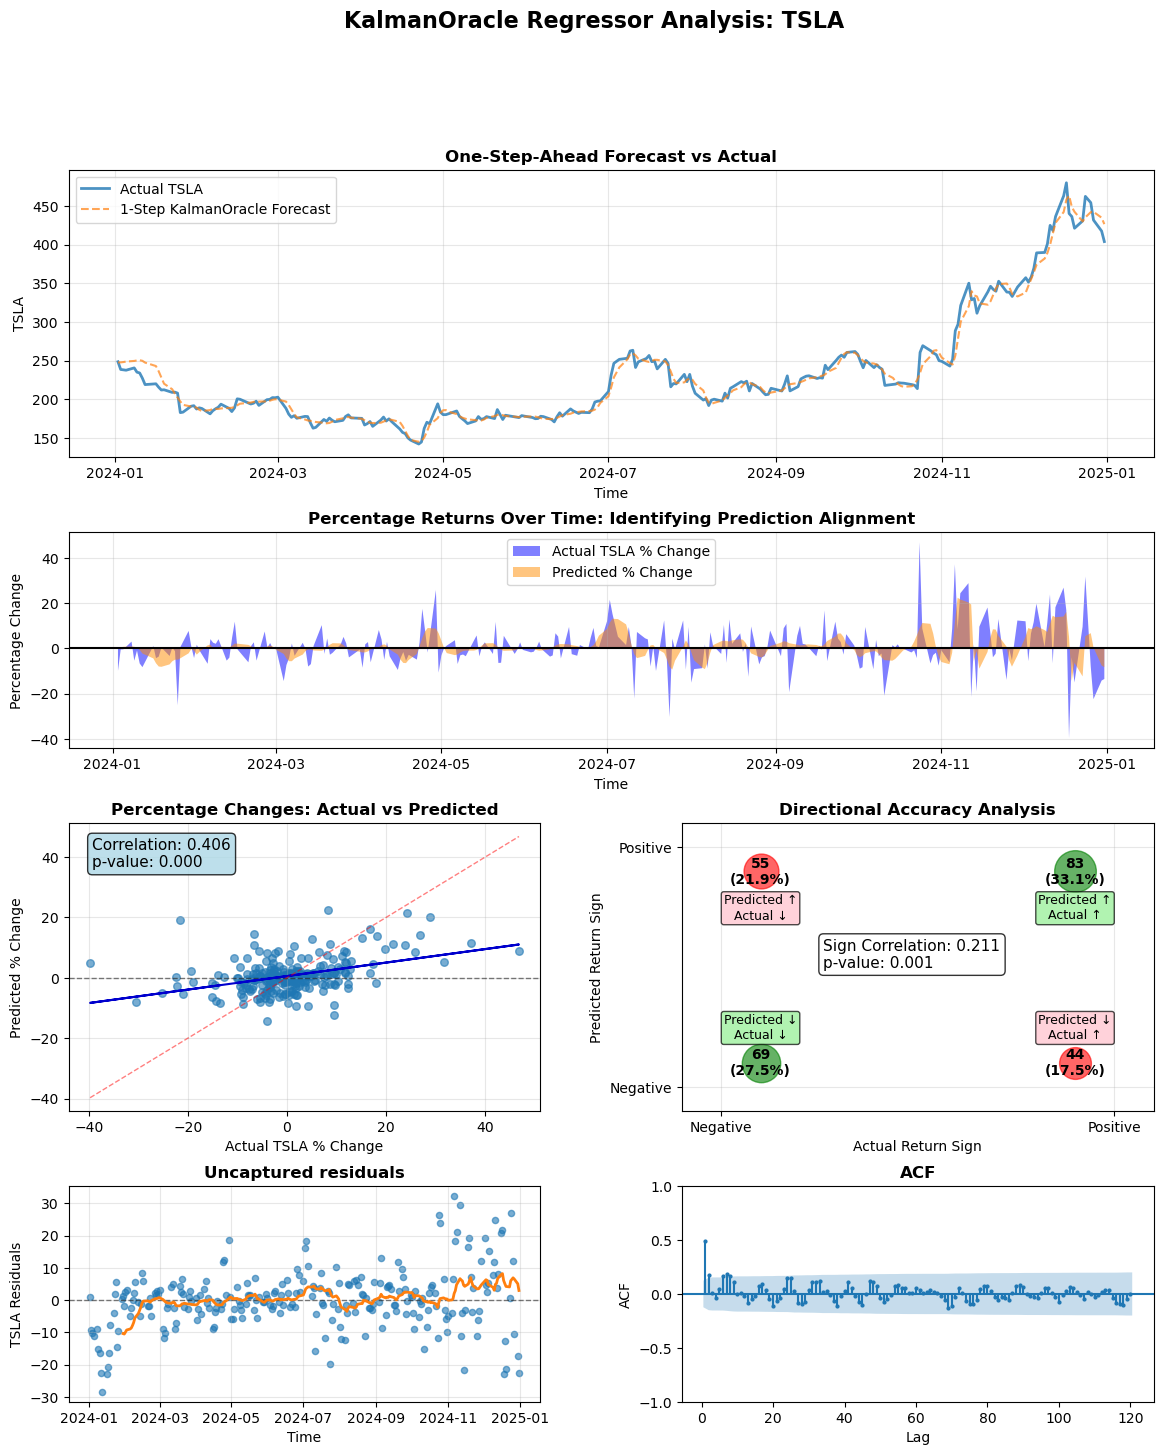

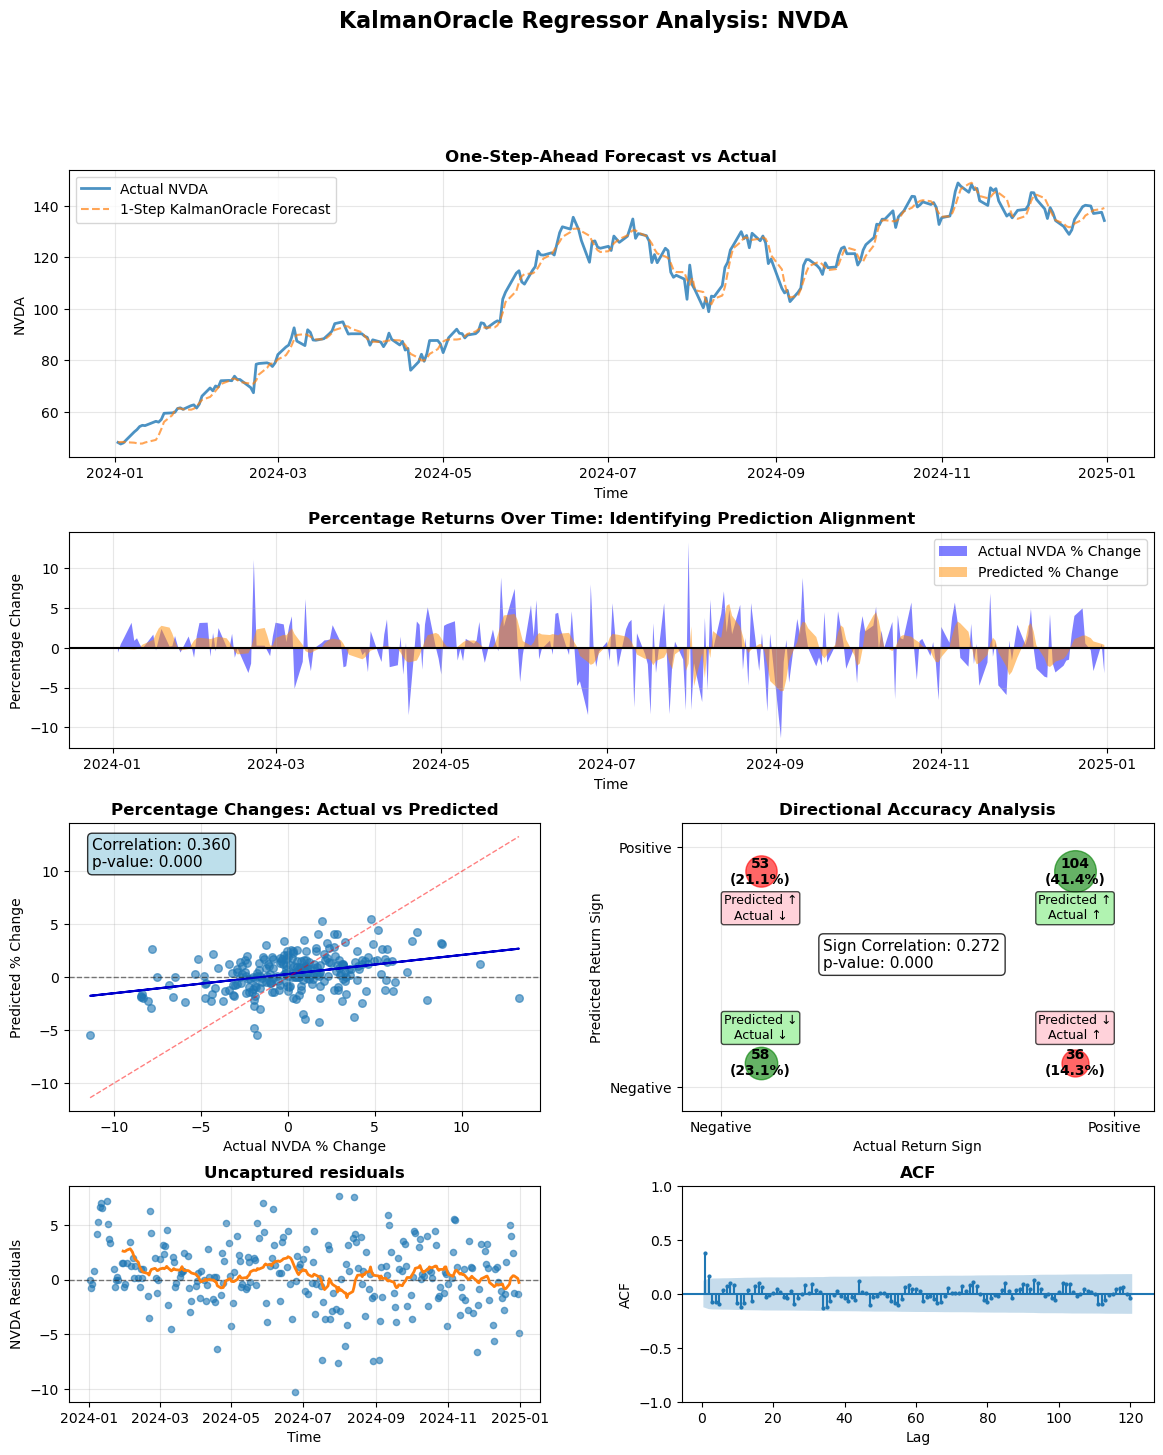

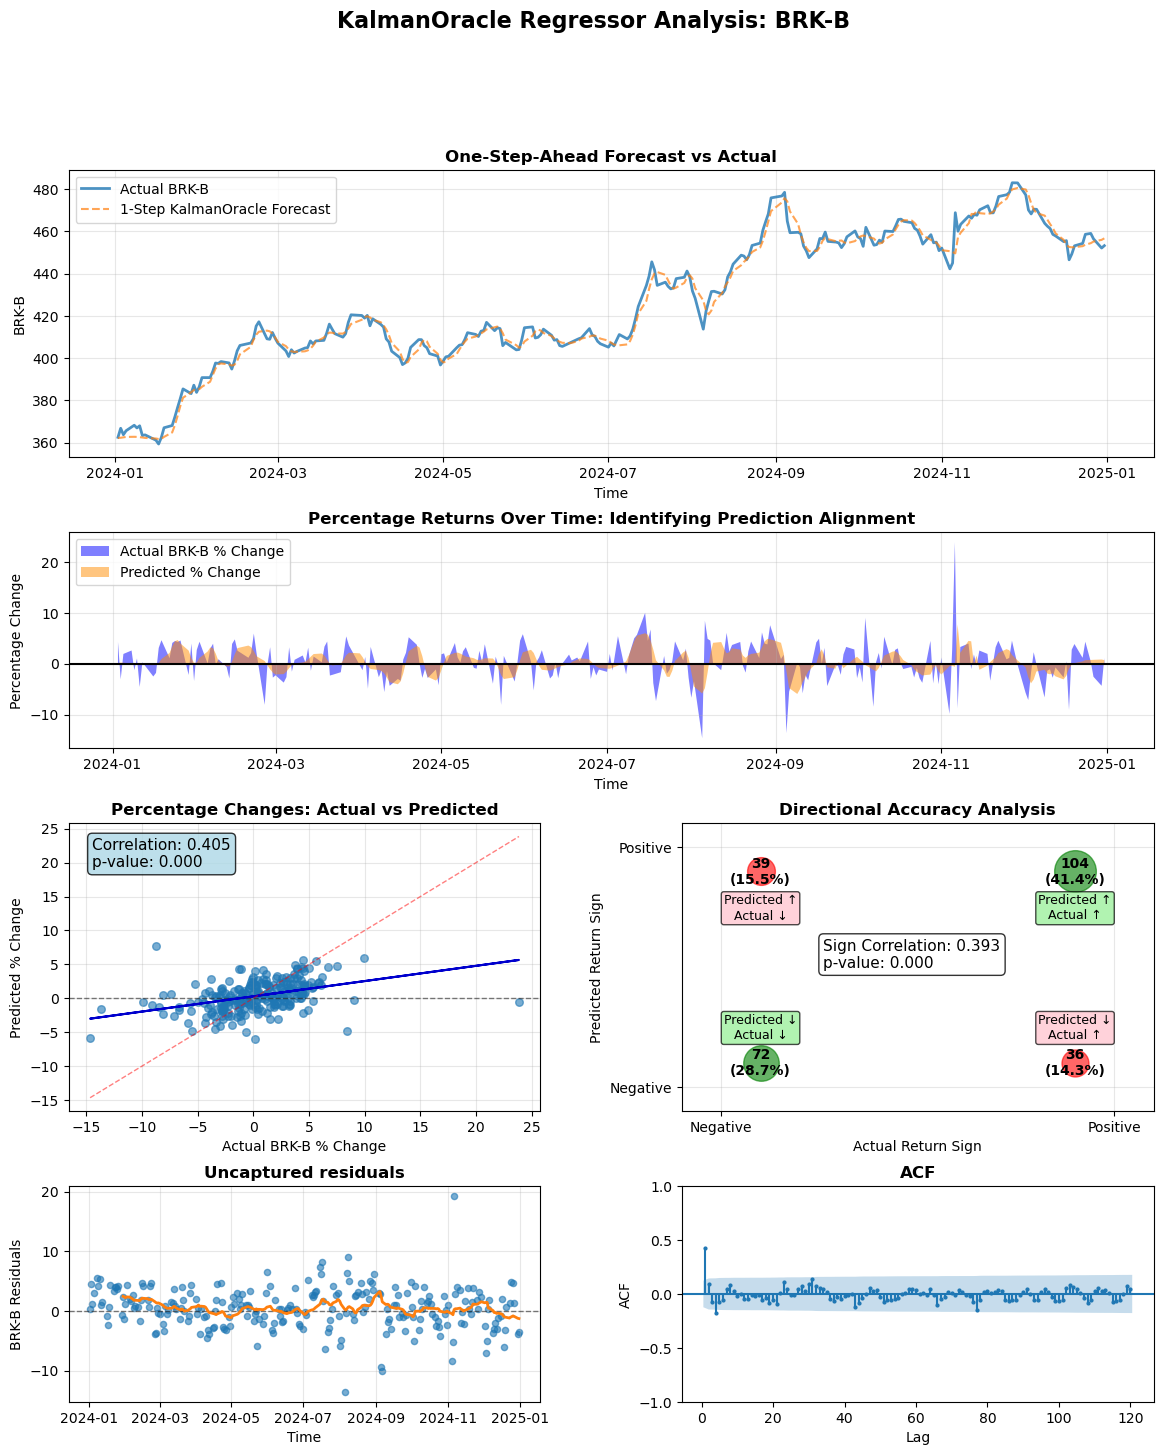

In [6]:
kalman1.plot_vs_actual(closing_data, window=40)

<h1>ARIMA</h1>

In [7]:
from utils.denoise import wavelet_denoise

<Axes: >

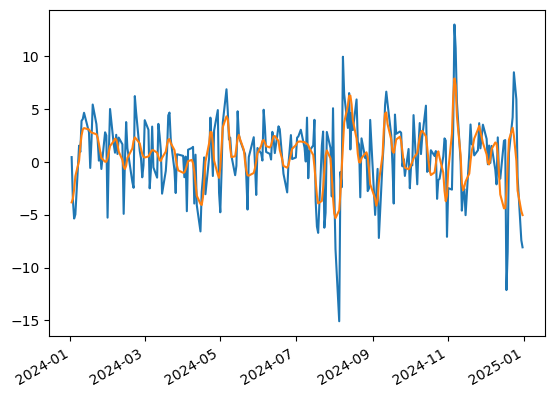

In [8]:
residue = kalman1.residuals(closing_data, window=40)
residue['SPY'].plot()
residue1 = {tk: wavelet_denoise(s, wavelet='db20', threshold_method='soft') for tk, s in residue.items()}
residue1['SPY'].plot()

In [9]:
from signal_modules._regressors.AR1 import AR1Oracle

ar1 = AR1Oracle()

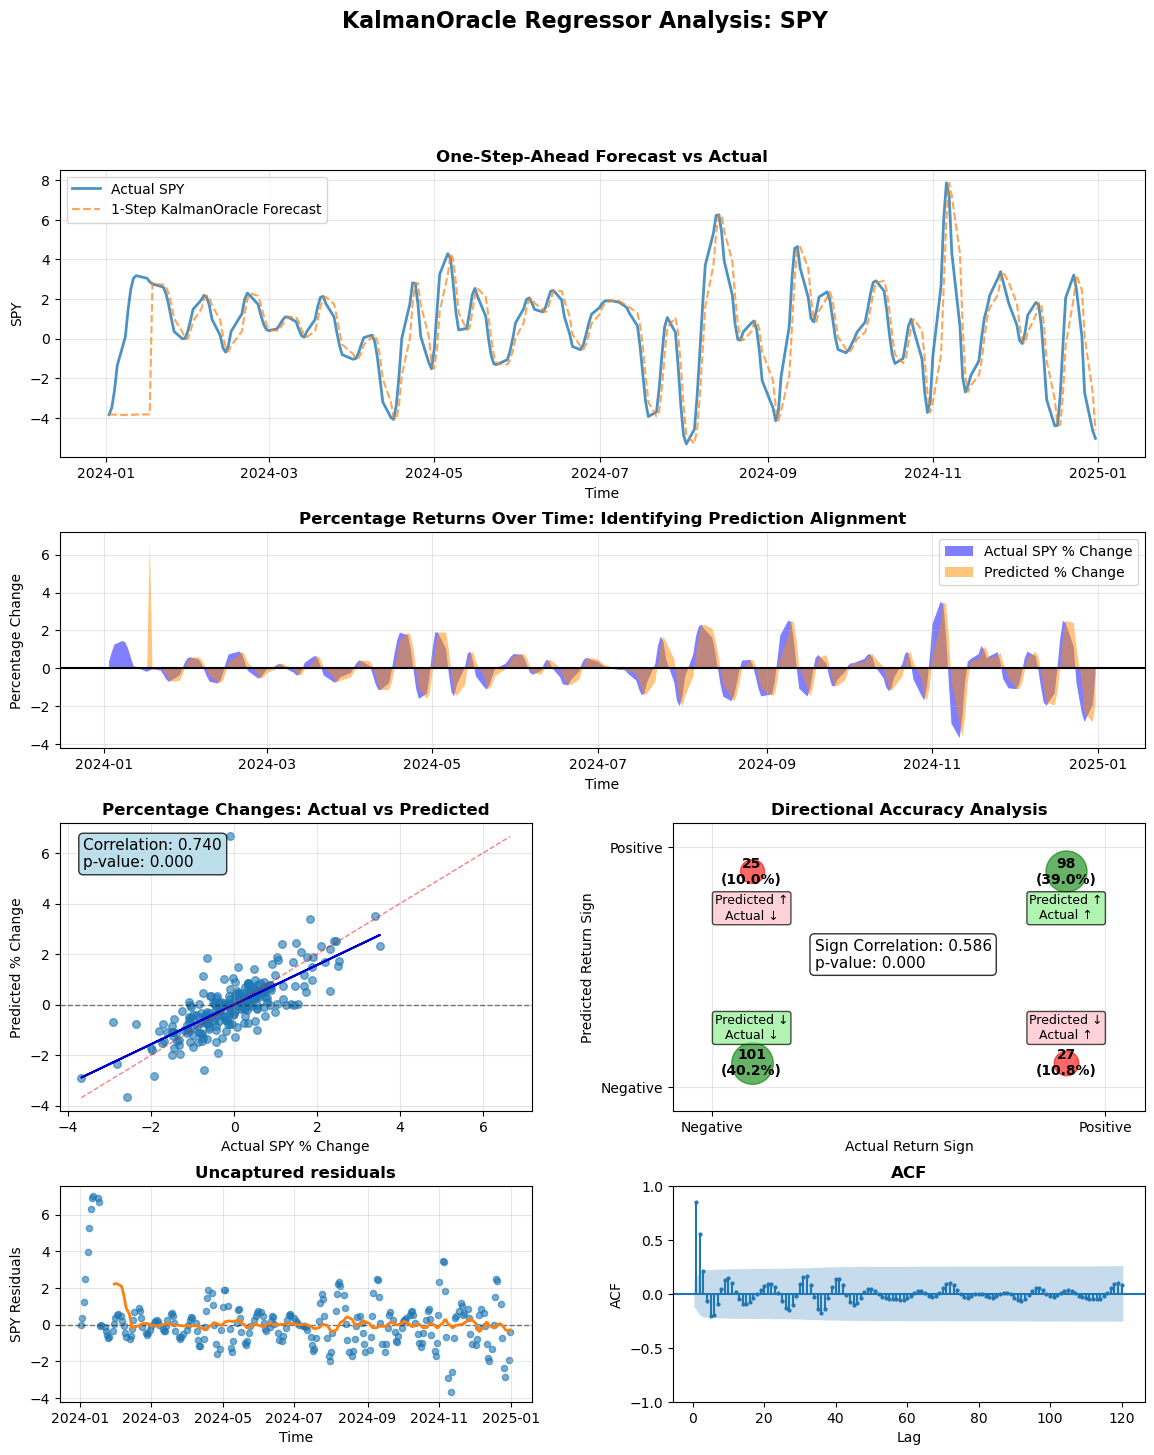

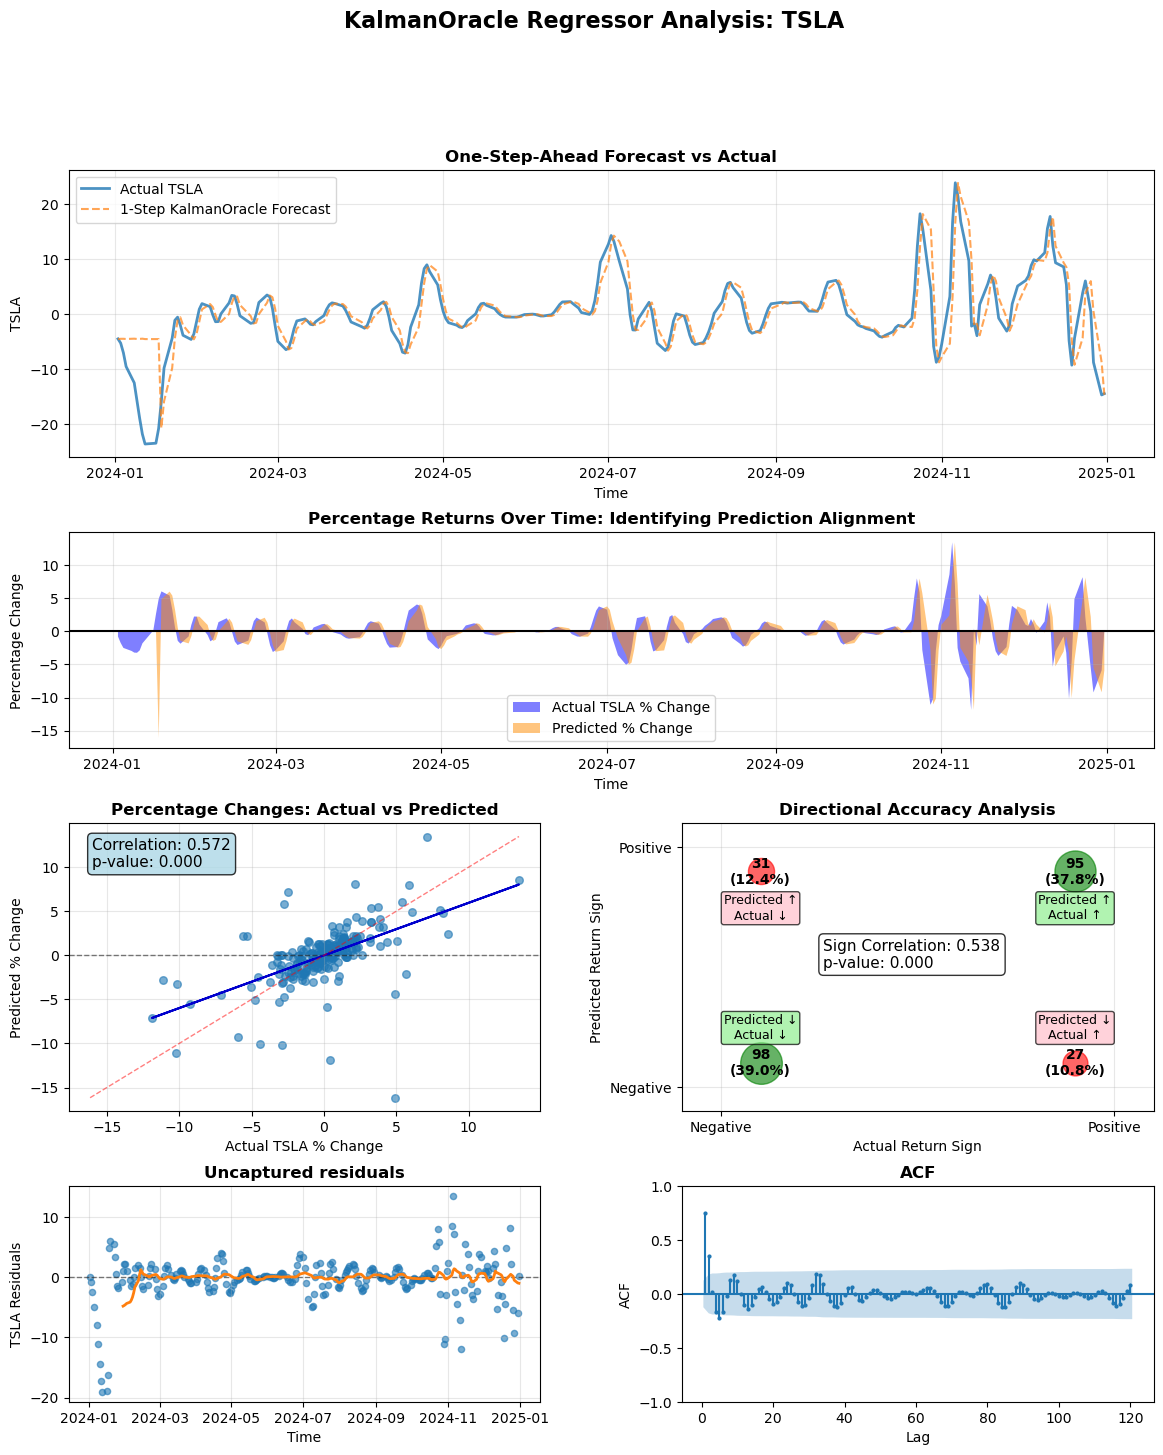

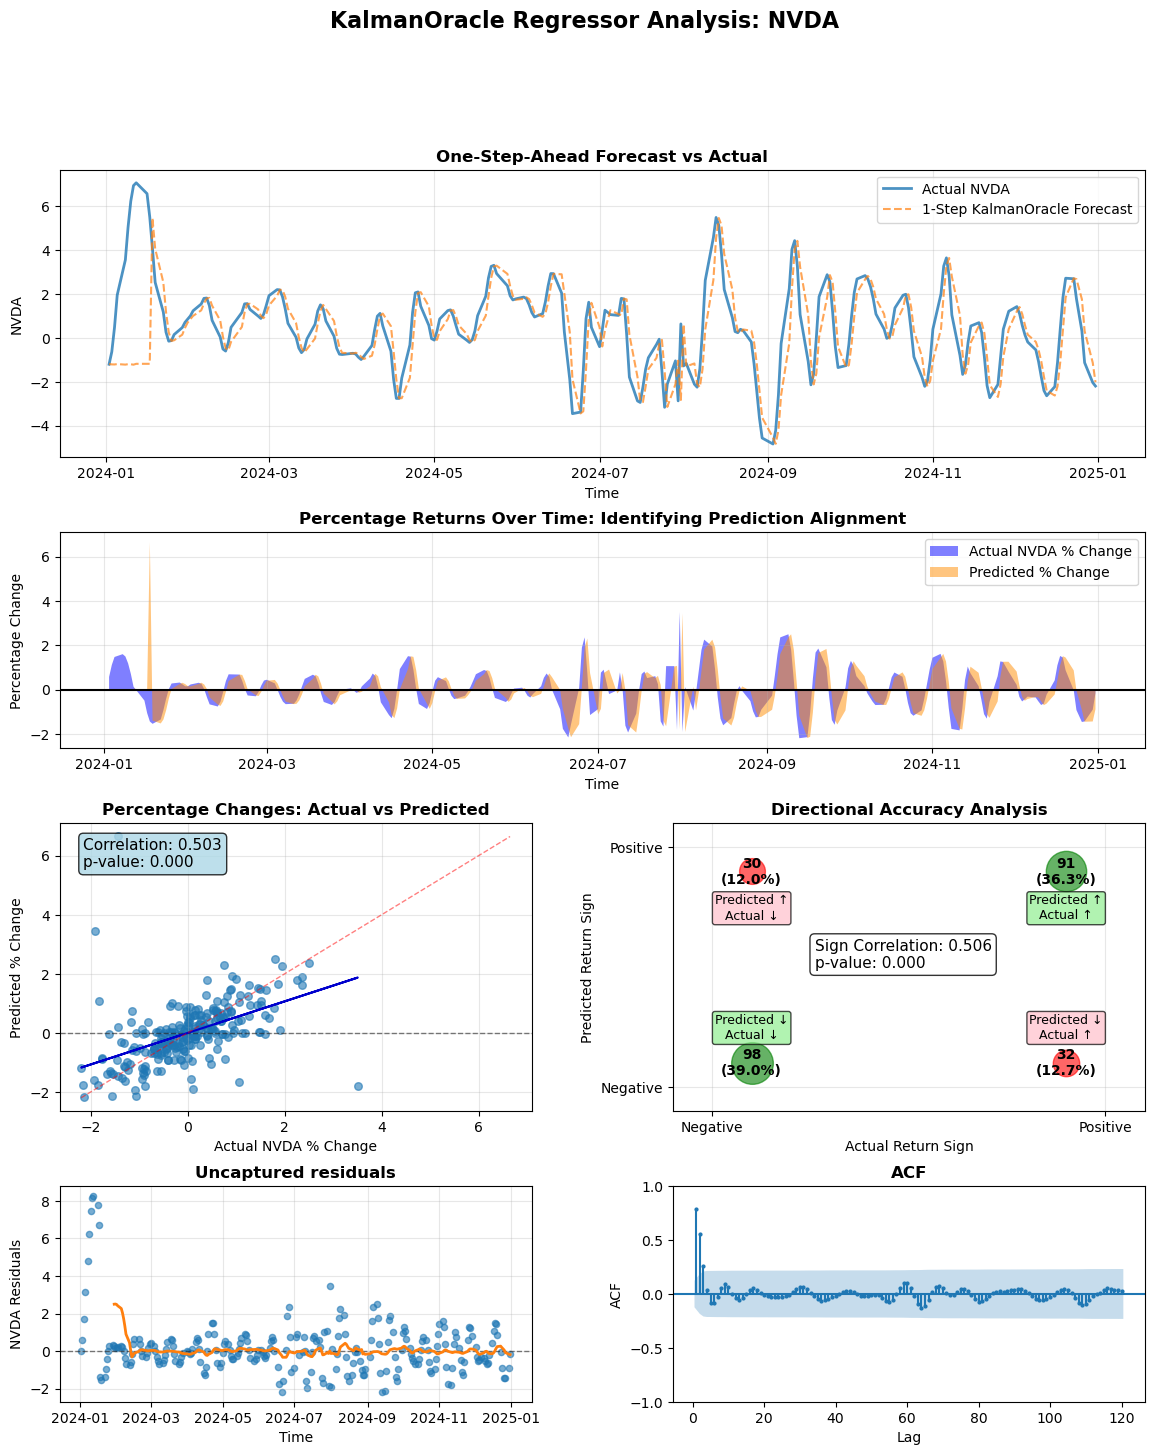

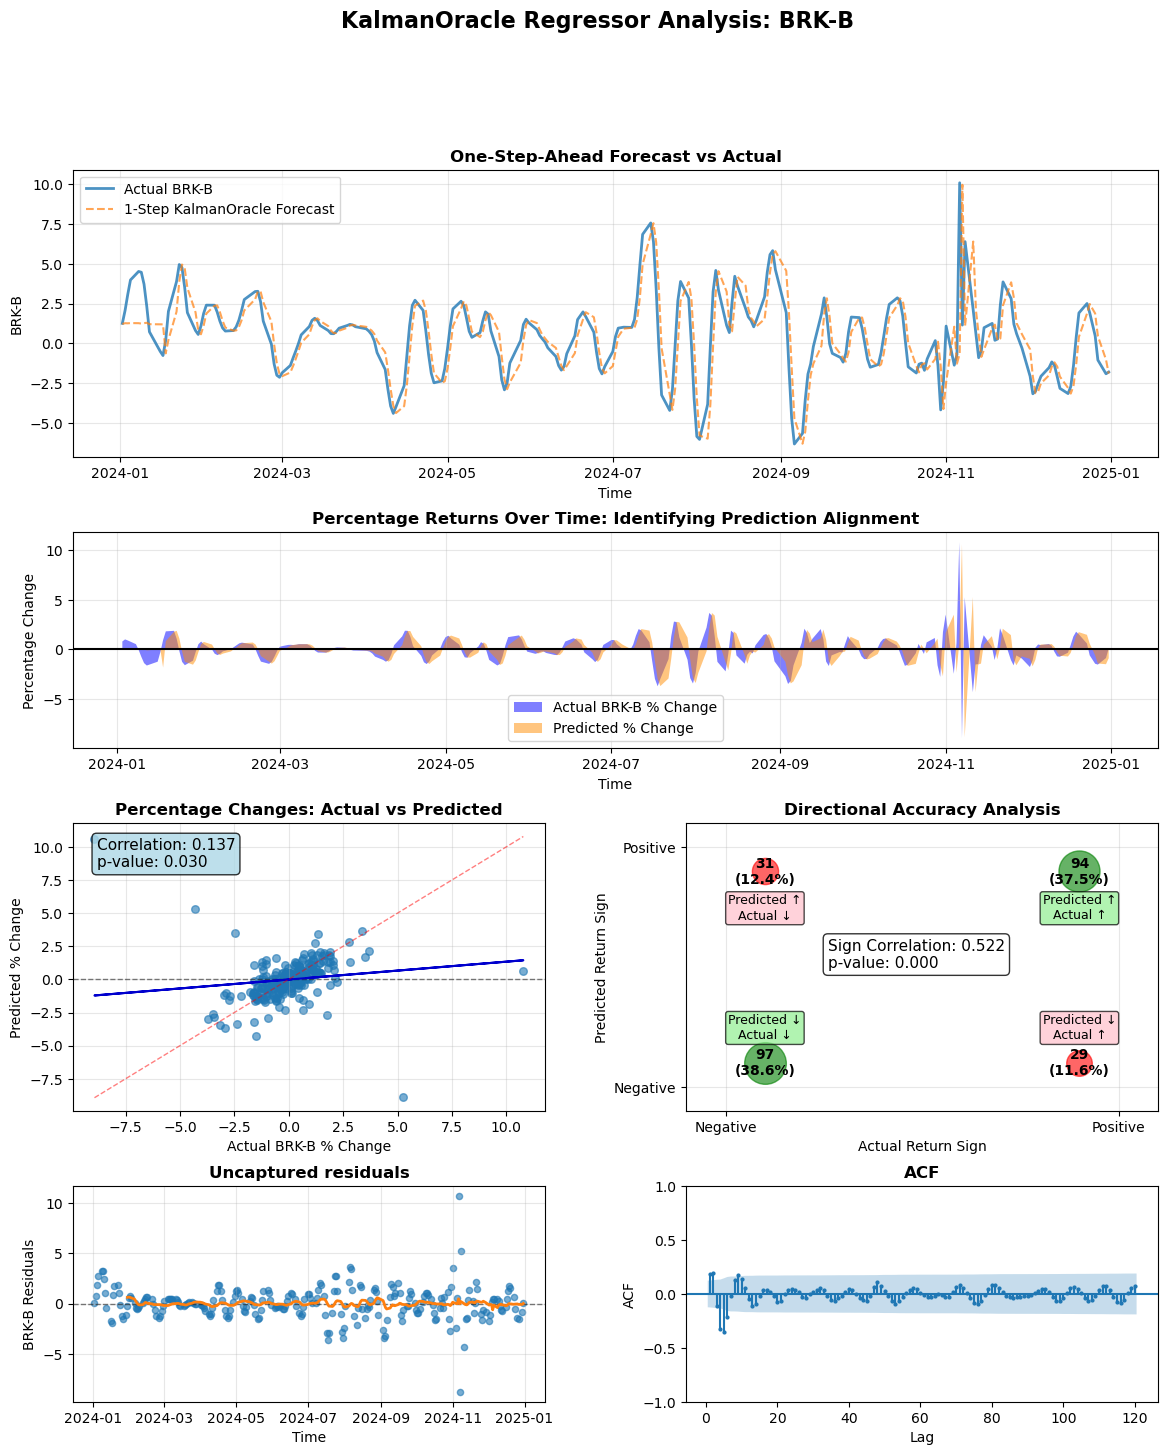

In [10]:
kalman1.plot_vs_actual(residue1, window=60)

In [18]:
np.array([1,2,3]) - 1

array([0, 1, 2])

<h1>Stack</h1>

In [11]:
stack = StackedOracle(
    oracles=[kalman1, kalman1], 
    windows=[60, 40], 
    weights=[1, 1]
)

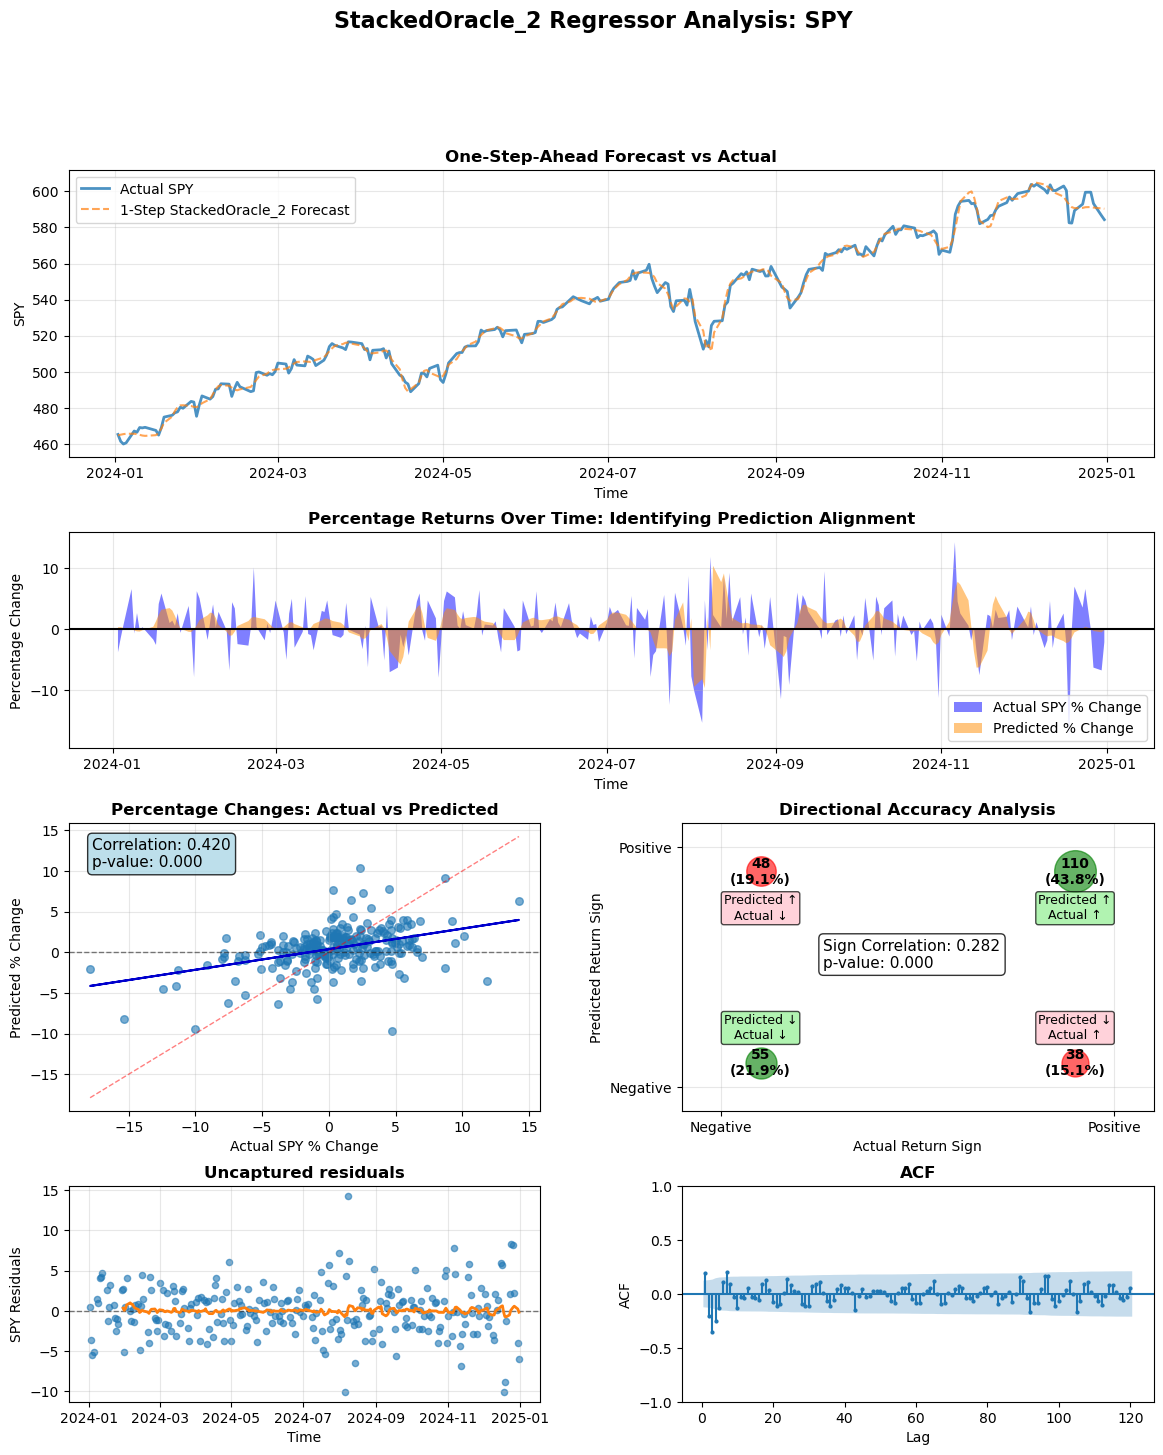

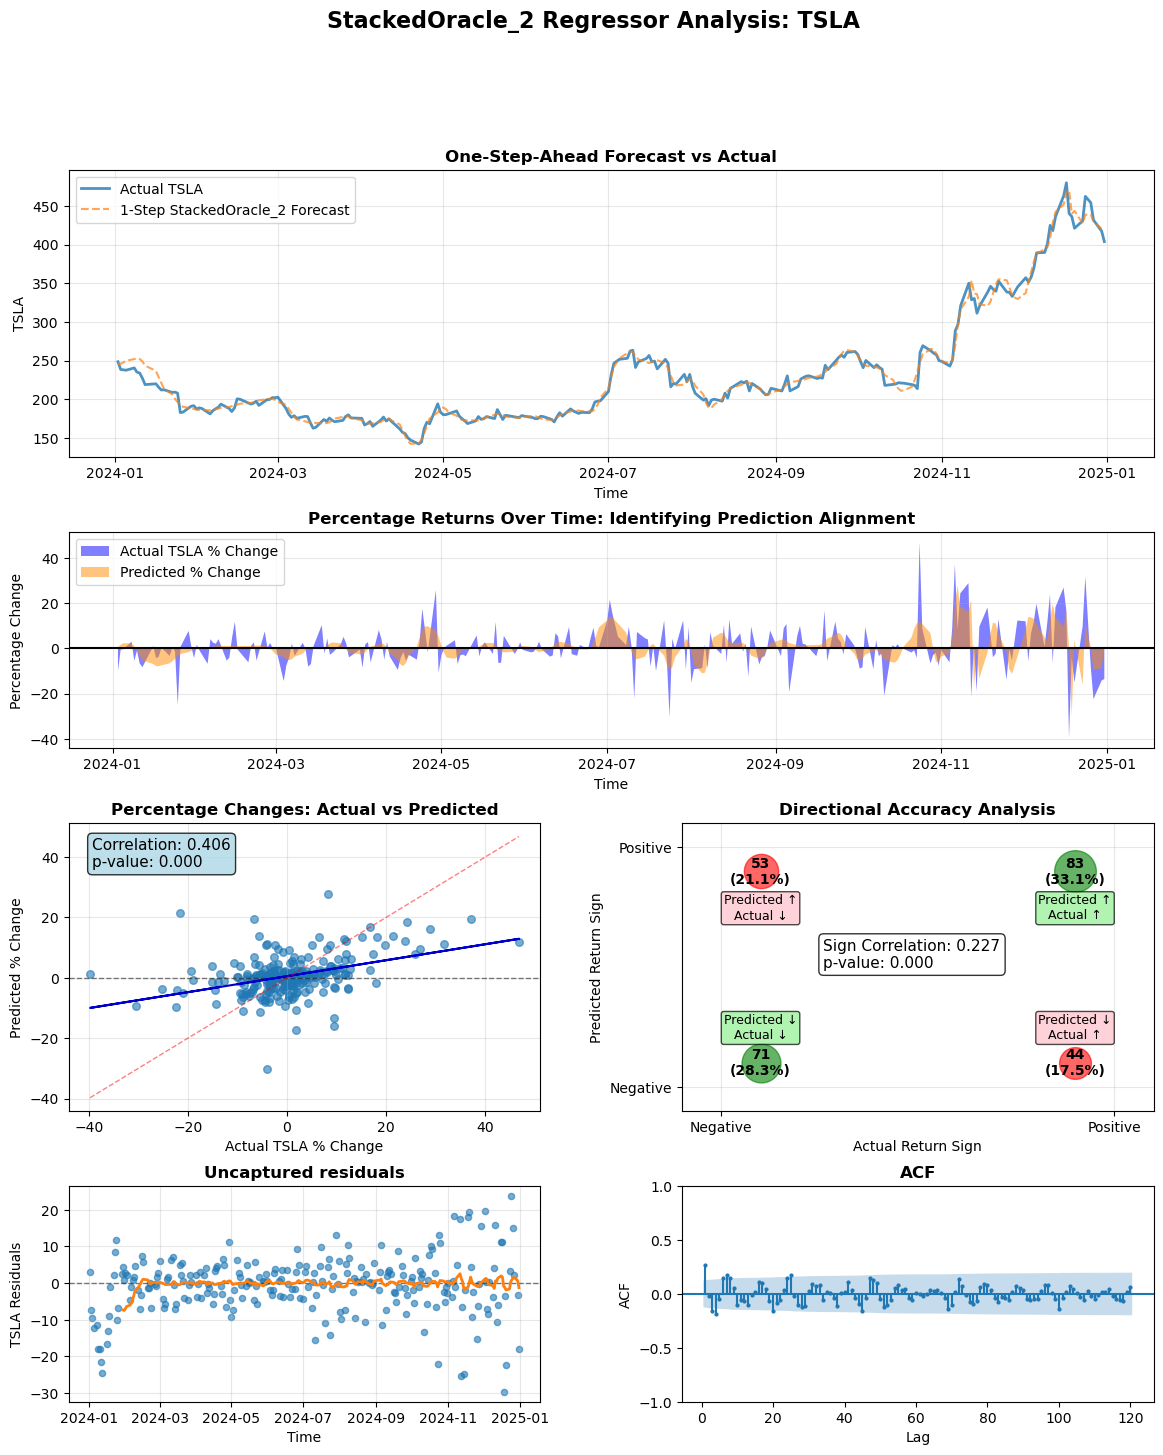

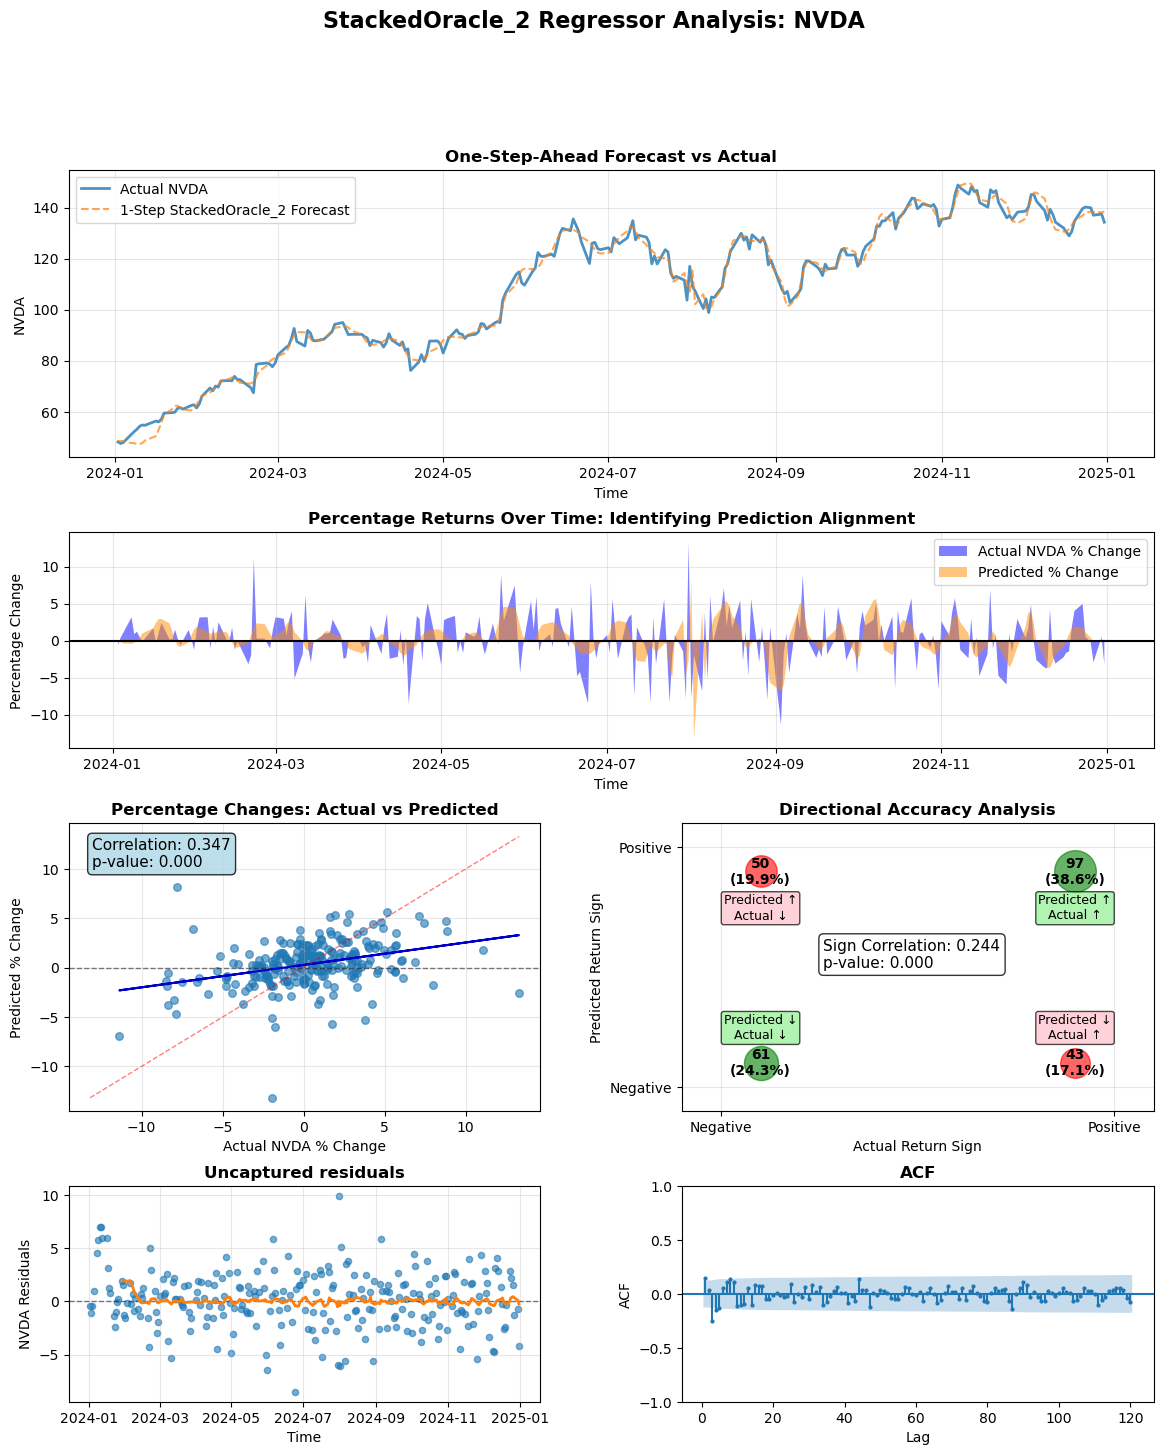

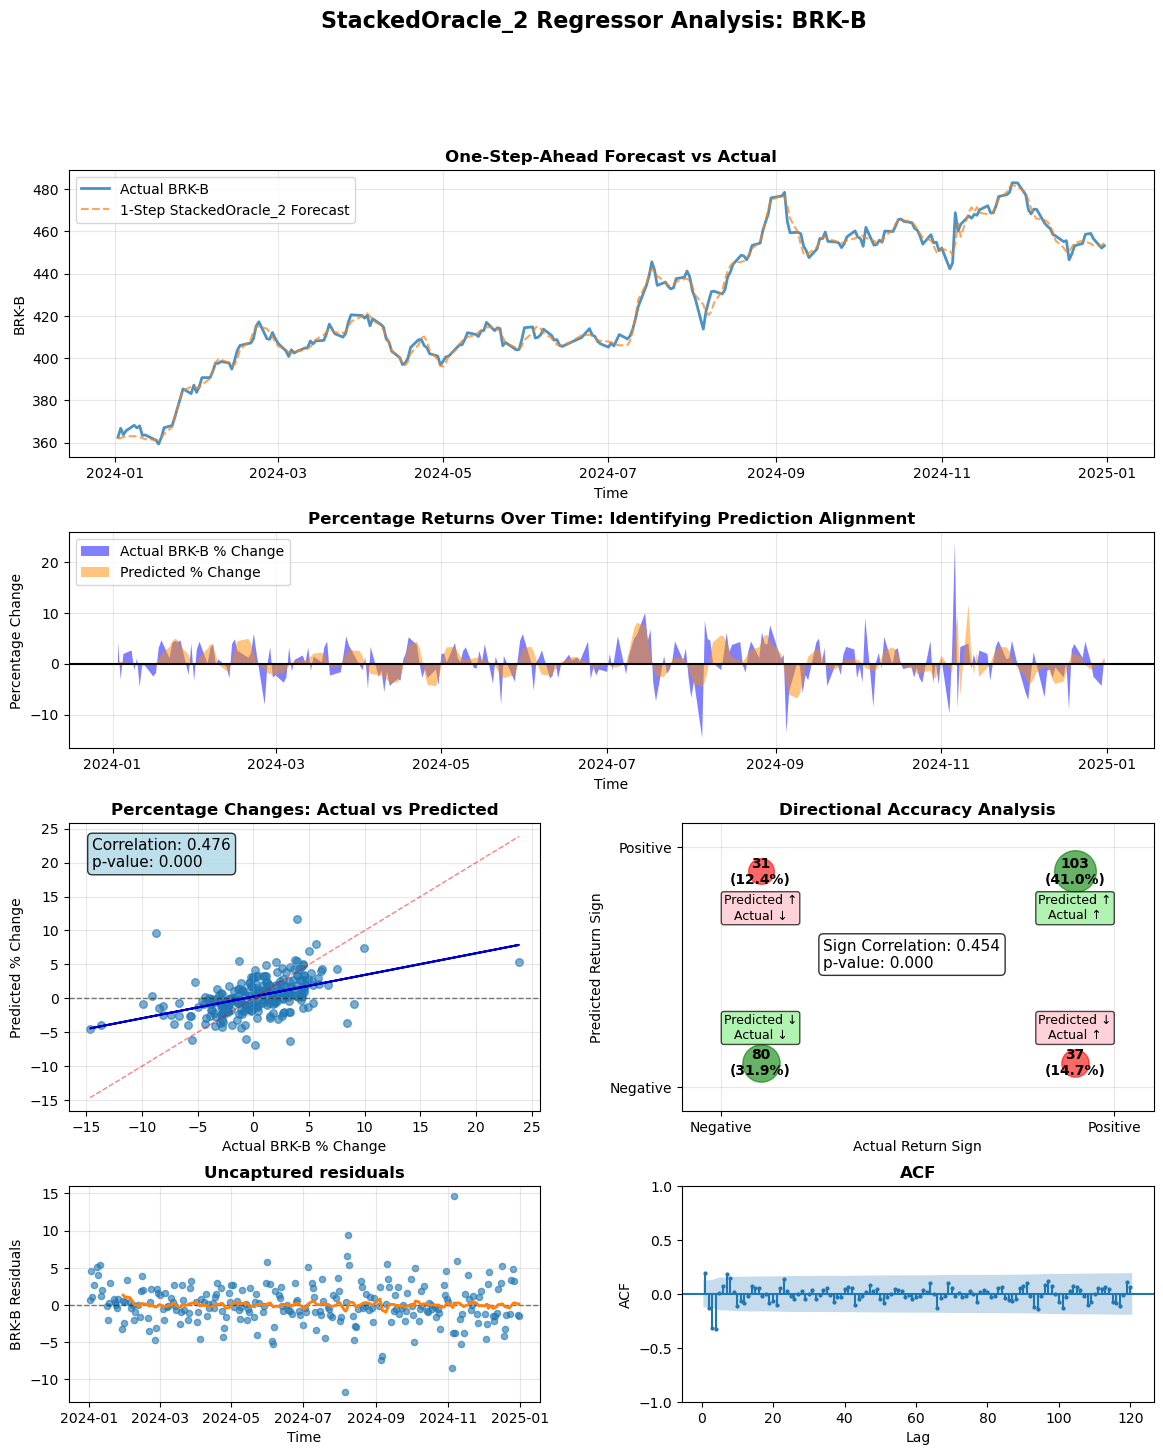

In [12]:
stack.plot_vs_actual(data=closing_data, window=60)